# Deep Learning - 1

## Chapter 4: Multi-layer Perceptron

### Training deep neural network and backpropagation

---------------

### Import

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

<img src="images/layer.png" alt="Drawing" width="1000"/>

### Model

#### Neural network

In [2]:
class Layer:
    """Representing a neural network layer"""
    
    def __init__(self, n_inputs, n_outputs):
        """Initlize weights and bias"""
        self.weights = np.random.randn(n_inputs, n_outputs)
        self.biases = np.zeros((1, n_outputs))
    
    def forward(self, inputs):
        """
        It multiplies the inputs by the weights 
        and then sums them, and then sums bias.
        """
        #To calculate gradient, remembering input values
        self.inputs = inputs
        #Calculate outputs' values
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        """Gradient with respect to parameters and input"""
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dresults = np.dot(dvalues, self.weights.T)

### Activation functions

#### Softmax Activation function

<img src="images/softmax.png" alt="Drawing" width="500"/>

In [3]:
class Activation_Softmax:
    """Softmax activation"""
    
    def forward(self, inputs):
        """Forward pass"""
        
        #Compute e^x for each element of inputs
        #Due to the overflow error, 
        #Maximum value of per sample subtract from each row
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                           keepdims=True))
        
        #Normalize them for each batch
        self.output = exp_values / np.sum(exp_values, 
                                          axis=1, keepdims=True)
    
    def backward(self, dvalues):
        """Gradient softmax"""
        
        #Initialize an array
        self.dresults = np.zeros(dvalues.shape)
        
        for i in range(len(dvalues)):
            #Reshape the single output
            single_output = self.output[i].reshape(-1, 1)
            
            #Calculate Jacobian matrix of the single output
            jacobian_matrix = np.diagflat(single_output) - \
                                np.dot(single_output, single_output.T)
            
            #Multiply the Jacobian matrix by the loss function derivative
            self.dresults[i] = np.dot(jacobian_matrix, dvalues[i])

#### ReLU Activation function

In [4]:
class Activation_ReLU:
    """ReLU activation"""
    
    def forward(self, inputs):
        """Forward pass"""
        
        #To calculate gradient, remembering input values
        self.inputs = inputs
        
        #Calculate outputs' values
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        """Backward pass"""
        
        self.dresults = self.inputs > 0
        self.dresults = self.dresults * dvalues

### Loss

#### MSE

In [5]:
class Loss_MSE():
    """MSE Loss function"""
    
    def forward(self, y_pred, y_true):
        """Forward pass"""     
        error = np.mean((y_pred - y_true) ** 2)
        return error
    
    def backward(self, y_pred, y_true):
        """Derivative of MSE with respect to preds"""
        
        #Number of samples
        samples = len(y_pred)
        
        #Number of output nodes
        outputs = len(y_pred[0])
        
        #Derivative of MSE
        self.dresults = 2 * (y_pred - y_true) / (outputs * samples)

#### Categorical Cross-entropy

In [6]:
class Loss_CategoricalCrossEntropy():
    """Cross entropy Loss function"""
    
    def forward(self, y_pred, y_true):
        """Forward pass"""
        y_pred += 1e-10
        y_pred = np.clip(y_pred, None, 1)
        true_prediction = np.sum(y_pred * y_true, axis=1)
        error = np.mean(-np.log(true_prediction)) 
        return error
    
    def backward(self, y_pred, y_true):
        """Derivative of CCE with respect to preds"""
        
        #Number of samples
        samples = len(y_pred)
        
        self.dresults = -y_true / (y_pred * samples)

#### Categorical Cross-entropy + Softmax 

In [7]:
class Loss_CategoricalCrossEntropy_Activation_SoftMax:
    """Cateogircal cross entropy loss and SoftMax function"""
    
    def __init__(self):
        """Initialize Softmax and CCE loss"""
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()
        
    def forward(self, inputs, y_true):
        """Forward pass"""
        self.activation.forward(inputs)
        return self.loss.forward(self.activation.output, y_true)
    
    def backward(self, y_pred, y_true):
        """Gradient of Categorical cross entropy + Softmax activation"""
        samples = len(y_pred)
        
        self.dresults = (y_pred - y_true) / samples        

### Accuracy

In [8]:
class Accuracy_Categorical:
    """Accuracy calculation for classification"""
    
    def calculate(self, y_pred, y_true):
        """Calculate the accuracy"""
        
        true = np.argmax(y_true, axis=1)
        pred = np.argmax(y_pred, axis=1)
        comparisons = true == pred
        
        accuracy = np.mean(comparisons)
        
        return accuracy

### Optimizer

#### Gradient descent 

In [9]:
class Optimizer_GD:
    """Gradient descent optimizer"""
    
    def __init__(self, alpha=1.):
        """Initialize hyperparameters"""
        self.alpha = alpha

    def update_parameters(self, layer):
        """Update parameters"""
        weights_delta = layer.dweights * self.alpha
        biases_delta = layer.dbiases * self.alpha
        
        #Update parameters
        layer.weights -= weights_delta
        layer.biases -= biases_delta

### Scaler

#### Standard Scaler

In [10]:
class Scaler_Standard:
    """Standard scaler"""
    
    def fit(self, data):
        """Find mean and std values"""
        self.means = data.mean(axis=0)
        self.stds = data.std(axis=0)
        return self
    
    def transform(self, data):
        """Transforming data"""
        return (data - self.means) / self.stds
    
    def fit_transform(self, data):
        """Fit and transform data"""
        return self.fit(data).transform(data)

#### MinMax Scaler

In [11]:
class Scaler_MinMax:
    """MinMax scaler"""
    
    def __init__(self, feature_range=(0,1)):
        """Initialize the feature range"""
        self.low, self.high = feature_range
    
    def fit(self, data):
        """Find min and max values"""
        self.min = data.min(axis=0)
        self.max = data.max(axis=0)
        return self
    
    def transform(self, data):
        """Transforming data"""
        data_std = (data - self.min) / (self.max - self.min)
        return data_std * (self.high - self.low) + self.low
    
    def fit_transform(self, data):
        """Fit and transform data"""
        return self.fit(data).transform(data)

#### Robust Scaler

In [12]:
class Scaler_Robust:
    """Robust scaler"""
    
    def fit(self, data):
        """Find median and iqr values"""
        self.medians = np.median(data, axis=0)
        self.p75, self.p25 = np.percentile(data, [75 ,25], axis=0)
        self.iqr = self.p75 - self.p25
        return self
    
    def transform(self, data):
        """Transforming data"""
        return (data - self.medians) / self.iqr
    
    def fit_transform(self, data):
        """Fit and transform data"""
        return self.fit(data).transform(data)

---------------

### Construct Data

In [13]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [14]:
def load_dataset(path):
    """
    Load the MNIST fashion dataset
    Convert the labels into one-hot vectors
    """

    labels = os.listdir(os.path.join(path))
    
    X = []
    Y = []
    
    for label in labels:
        for file in os.listdir(os.path.join(path, label)):
            image = cv2.imread(os.path.join(path, label, file),
                                  cv2.IMREAD_UNCHANGED)
            X.append(image)
            Y.append(label)
    
    
    X = np.array(X)
    Y = np.array(Y).astype('uint8')
    Y = np.eye(len(labels))[Y].astype('uint8')
    
    return X, Y

In [15]:
train_dataset, train_labels = load_dataset('../dataset/train')
test_dataset, test_labels = load_dataset('../dataset/test')

In [16]:
train_dataset.shape

(60000, 28, 28)

#### Flatten the every image

In [17]:
train_dataset = train_dataset.reshape(len(train_dataset), -1)
test_dataset = test_dataset.reshape(len(test_dataset), -1)

In [18]:
test_dataset.shape

(10000, 784)

#### Data shuffling

In [19]:
indexes = np.array(range(len(train_dataset)))
np.random.shuffle(indexes)

train_dataset = train_dataset[indexes]
train_labels = train_labels[indexes]

### Data Pre-Processing

In [20]:
scaler = Scaler_MinMax((-1,1))
scaler.min = 0
scaler.max = 255
train_dataset = scaler.transform(train_dataset)
test_dataset = scaler.transform(test_dataset)

In [21]:
train_dataset.min()

-1.0

### Set Hyperparameters

In [26]:
max_epoch = 500
alpha = 0.1
batch_size = 128

### Initialize the model

In [23]:
layer1 = Layer(784, 512)
activation1 = Activation_ReLU()
layer2 = Layer(512, 10)

### Initlize optimizer and loss function

In [24]:
loss = Loss_CategoricalCrossEntropy_Activation_SoftMax()
accuracy = Accuracy_Categorical()
optimizer = Optimizer_GD(alpha=alpha)

### Training the model

In [25]:
train_steps = len(train_dataset) // batch_size
if train_steps * batch_size < len(train_dataset):
    train_steps += 1

In [27]:
for epoch in range(max_epoch):
    train_error = 0
    train_accuracy = 0
    
    for i in range(train_steps):
        batch_start = i * batch_size
        batch_end = (i+1) * batch_size
        
        input = train_dataset[batch_start:batch_end]
        true = train_labels[batch_start:batch_end]
        
        #Forward pass
        layer1.forward(input)
        activation1.forward(layer1.output)
        layer2.forward(activation1.output)
        train_error += loss.forward(layer2.output, true) / train_steps
        train_accuracy += accuracy.calculate(layer2.output, true) / train_steps
        
        #Backward pass
        loss.backward(loss.activation.output, true)
        layer2.backward(loss.dresults)
        activation1.backward(layer2.dresults)
        layer1.backward(activation1.dresults)


        optimizer.update_parameters(layer2)
        optimizer.update_parameters(layer1)
    
    print(f'epoch: {epoch},',
          f'Train error: {train_error:.3f},',
          f'Train accuracy: {train_accuracy:.3f}')

epoch: 0, Train error: 3.659, Train accuracy: 0.744
epoch: 1, Train error: 1.730, Train accuracy: 0.758
epoch: 2, Train error: 1.257, Train accuracy: 0.767
epoch: 3, Train error: 1.037, Train accuracy: 0.776
epoch: 4, Train error: 0.909, Train accuracy: 0.784
epoch: 5, Train error: 0.817, Train accuracy: 0.793
epoch: 6, Train error: 0.754, Train accuracy: 0.800
epoch: 7, Train error: 0.699, Train accuracy: 0.807
epoch: 8, Train error: 0.653, Train accuracy: 0.813
epoch: 9, Train error: 0.615, Train accuracy: 0.818
epoch: 10, Train error: 0.584, Train accuracy: 0.823
epoch: 11, Train error: 0.558, Train accuracy: 0.827
epoch: 12, Train error: 0.533, Train accuracy: 0.831
epoch: 13, Train error: 0.517, Train accuracy: 0.835
epoch: 14, Train error: 0.500, Train accuracy: 0.837
epoch: 15, Train error: 0.484, Train accuracy: 0.841
epoch: 16, Train error: 0.474, Train accuracy: 0.842
epoch: 17, Train error: 0.460, Train accuracy: 0.846
epoch: 18, Train error: 0.450, Train accuracy: 0.849
epo

epoch: 154, Train error: 0.215, Train accuracy: 0.923
epoch: 155, Train error: 0.214, Train accuracy: 0.924
epoch: 156, Train error: 0.214, Train accuracy: 0.924
epoch: 157, Train error: 0.213, Train accuracy: 0.924
epoch: 158, Train error: 0.212, Train accuracy: 0.925
epoch: 159, Train error: 0.212, Train accuracy: 0.925
epoch: 160, Train error: 0.211, Train accuracy: 0.925
epoch: 161, Train error: 0.211, Train accuracy: 0.925
epoch: 162, Train error: 0.210, Train accuracy: 0.926
epoch: 163, Train error: 0.210, Train accuracy: 0.926
epoch: 164, Train error: 0.209, Train accuracy: 0.926
epoch: 165, Train error: 0.208, Train accuracy: 0.926
epoch: 166, Train error: 0.208, Train accuracy: 0.927
epoch: 167, Train error: 0.207, Train accuracy: 0.927
epoch: 168, Train error: 0.207, Train accuracy: 0.927
epoch: 169, Train error: 0.206, Train accuracy: 0.927
epoch: 170, Train error: 0.206, Train accuracy: 0.927
epoch: 171, Train error: 0.205, Train accuracy: 0.928
epoch: 172, Train error: 0.2

epoch: 306, Train error: 0.149, Train accuracy: 0.947
epoch: 307, Train error: 0.149, Train accuracy: 0.948
epoch: 308, Train error: 0.149, Train accuracy: 0.948
epoch: 309, Train error: 0.148, Train accuracy: 0.948
epoch: 310, Train error: 0.148, Train accuracy: 0.948
epoch: 311, Train error: 0.148, Train accuracy: 0.948
epoch: 312, Train error: 0.147, Train accuracy: 0.948
epoch: 313, Train error: 0.147, Train accuracy: 0.948
epoch: 314, Train error: 0.147, Train accuracy: 0.948
epoch: 315, Train error: 0.146, Train accuracy: 0.949
epoch: 316, Train error: 0.146, Train accuracy: 0.949
epoch: 317, Train error: 0.146, Train accuracy: 0.949
epoch: 318, Train error: 0.146, Train accuracy: 0.949
epoch: 319, Train error: 0.145, Train accuracy: 0.949
epoch: 320, Train error: 0.145, Train accuracy: 0.949
epoch: 321, Train error: 0.145, Train accuracy: 0.949
epoch: 322, Train error: 0.144, Train accuracy: 0.949
epoch: 323, Train error: 0.144, Train accuracy: 0.950
epoch: 324, Train error: 0.1

epoch: 458, Train error: 0.111, Train accuracy: 0.962
epoch: 459, Train error: 0.111, Train accuracy: 0.962
epoch: 460, Train error: 0.110, Train accuracy: 0.962
epoch: 461, Train error: 0.110, Train accuracy: 0.962
epoch: 462, Train error: 0.110, Train accuracy: 0.962
epoch: 463, Train error: 0.110, Train accuracy: 0.962
epoch: 464, Train error: 0.109, Train accuracy: 0.962
epoch: 465, Train error: 0.109, Train accuracy: 0.962
epoch: 466, Train error: 0.109, Train accuracy: 0.962
epoch: 467, Train error: 0.109, Train accuracy: 0.962
epoch: 468, Train error: 0.109, Train accuracy: 0.962
epoch: 469, Train error: 0.108, Train accuracy: 0.962
epoch: 470, Train error: 0.108, Train accuracy: 0.963
epoch: 471, Train error: 0.108, Train accuracy: 0.963
epoch: 472, Train error: 0.108, Train accuracy: 0.963
epoch: 473, Train error: 0.108, Train accuracy: 0.963
epoch: 474, Train error: 0.108, Train accuracy: 0.963
epoch: 475, Train error: 0.107, Train accuracy: 0.963
epoch: 476, Train error: 0.1

### Testing the model

In [28]:
test_steps = len(test_dataset) // batch_size
if test_steps * batch_size < len(test_dataset):
    test_steps += 1

In [29]:
test_error = 0
test_accuracy = 0

for i in range(test_steps):
    batch_start = i * batch_size
    batch_end = (i+1) * batch_size
    
    input = test_dataset[batch_start:batch_end]
    true = test_labels[batch_start:batch_end]
    
    layer1.forward(input)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    test_error += loss.forward(layer2.output, true) / test_steps
    test_accuracy += accuracy.calculate(layer2.output, true) / test_steps

In [30]:
print(f'Test error: {test_error:.3f},',
      f'Test accuracy: {test_accuracy:.3f}')

Test error: 1.211, Test accuracy: 0.843


In [55]:
random_idx = np.random.randint(len(test_dataset))
random_idx

3056

In [56]:
test_input = test_dataset[random_idx]
test_label = test_labels[random_idx]

In [57]:
layer1.forward(test_input)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
loss.forward(layer2.output, test_label)

4.974969827525924e-05

true: 3 class: Dress 
pred: 3 class: Dress


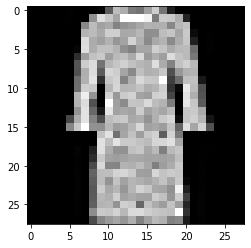

In [58]:
test_label = np.argmax(test_label)
test_pred = np.argmax(loss.activation.output)
print(f'true: {test_label}',
      f'class: {classes[test_label]}',
      f'\npred: {test_pred}',
      f'class: {classes[test_pred]}')
img = test_input.reshape((28, 28))
plt.imshow(img, cmap='gray')
plt.show()